This time, we are facing a task that separate mixed sounds through probability theory. In the simple case, to separate $n$ sound sources, we have $n$ microphones at different position recording all received sound. And, we need to estimate all sound sources according to these mixed records. The basic idea we used here is assuming source sounds follow a specific distribution (prior), and we maximize likelihood of mixed sound records when given a mixing matrix to find the optimal mixing matrix. Then use it to calculate source sounds.

### Load Audios from Files

At first we need be able to load audio file into memory for calculation. Here, we use package **scipy**. You can install it through **pip**, if necessary.

In [12]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')
_, dataSpeech = wavfile.read('data/speech.wav')

Currently, sound tracks is loaded as type of '*int16*', which is not convenient for calculation. We need to normalize them into range of $[-0.5, 0.5]$. Here, we create a function to do this.

In [13]:
import numpy as np

def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

Then, we get all source sound tracks as a matrix, in which each sound track is a row:

In [14]:
gtruthS = audionorm([dataBach, dataSpeech])

### Make a simple Audio Mixer

Before, we actaully start to separate the sources blindly, it's necessary to compose mixed sound tracks at first. Here, we use following steps to implement it:
1. generate a random matrix (mixing matrix) with uniform distribution in range $[0,1]$
2. multiply mixing matrix with matrix of source sound tracks

In [15]:
def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

As told in lecture, the $i$-th row of mixing matrix corresponds to weights of each source sound track in $i$-th sound mixture. While, each colomn of mixing matrix represends the bases of sound mixture. For illustration purpose, we create a plotting function to show mixture data point with axis (column vector of mixing matrix).

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt

def drawDataWithMixingMatrix(data, mat):
    # plot data points
    plt.scatter(data[0], data[1], s=1)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')

Now, we get our mixed sound tracks with ground truth of mixing matrix, and plot them to see it visually. You should play with it to get more sense about what mixing matrix is. And this would help you to understand and implement the algorithm in this assignment.

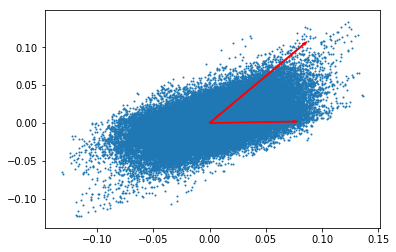

In [17]:
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

In [18]:
print(X.shape)

(2, 132362)


Save them into files, and then you can hear them through your system's audio player.

In [19]:
wavfile.write('data/mixedTrackA.wav', srate, X[0])
wavfile.write('data/mixedTrackB.wav', srate, X[1])

### Build Up Optimization Functions

To separate source sound tracks, we need to optmize mixing matrix to maximize likelihood of sound mixtures with given mixing matrix. This time you have to implement this algorithm by yourself. If you want to run following part of demo directly, you should implement the function with name *bss* and return recovered sound tracks.

If you have no idea about how to start, here is some guideline:
1. initialize an identity matrix as your intial mixing matrix
2. calculate source sound tracks with current mixing matrix
3. calculate gradient of mixing matrix
4. update mixing matrix with its gradient multiply with a step size (if your method cannot converge, try a smaller step size)
5. go to step 2 until stop criteria fulfilled
6. calculate recovered source sound tracks with final mixing matrix
6. return mixing matrix and recovered source sound tracks

During the optimization, you should output some information to help you see the state of your algorithm. The way we used in our implementation is print current log-likelihood. A better way to do it is plotting the mixing matrix with mixture data with function we provide above.

Here, we just refer an external file, which we don't provide, to import function *bss*.

In [8]:
from bsslib import bss

In [44]:
# dA = -A(zs^T + I)
def bss(data):
    intial_matrix = np.identity(data.shape[0])
    zero = np.zeros((data.shape[0],data.shape[1]))
    temp1  = np.zeros(data.shape)
    I =  np.asarray([[1, 0],[0, 1]])
    temp4 = np.asarray([[1,0],[0,1]])
    i=0
    while i<=100:
        i = i+1
        s = np.matmul(np.linalg.inv(intial_matrix), data)
        z = -np.copy(s)
        dA = - np.matmul(intial_matrix, ((np.matmul(z,s.transpose())) + I))
        temp2 = np.copy(intial_matrix)
        intial_matrix = intial_matrix +( dA * 0.01)
        temp3 = intial_matrix - temp4
        
    result = np.matmul(np.linalg.inv(intial_matrix), data)
    return intial_matrix, result


### Verify Implementation with Synthetic Data

Before actually apply this algorithm to sound data. It's a good habbit to check the implementation with synthetic data, and debug it if necessary. Here, we require you to write a function to generate synthetic mixture sound tracks with given mixing matrix. We use a function named *syntheticDataGenerate* from external file. It should return a matrix in size $2 \times n$, where $n$ is the quantity of data points specified in argument of function call. To implement this function, you should follow these two steps:
1. generate a $2 \times n$ matrix with random elements following standard Laplace distribution
2. use given mixing matrix with random matrix generate in first step compose the mixture

In [22]:
def syntheticDataGenerate(mat, nsamples): 
    random_matrix = np.zeros((2,nsamples)) 
    for i in range(2):
        for j in range(nsamples):
            random_matrix[i,j] =  np.random.laplace()
    result_matrix = np.dot(mat,random_matrix)
    return result_matrix

In [45]:
#from bsslib import syntheticDataGenerate

# quantity of data points
nsamples = 10000
# specific mixing matrix (for illustration purpose)
verifyA = np.asarray([[-1, 1],[2, 2]])
# generate synthetic data
synthData = syntheticDataGenerate(verifyA, nsamples)
# do optimization with bss function
estimateA, recoverData = bss(synthData)

We can compare mixing matrix and recovered one by print them. It's simple and straight-forward. But, here we would use the plotting function above to compare them. We also create a function to make comparision more convenient. This methods is helpful when you get equivalent result but different in concrete numbers.

In [46]:
def compareMixingMatrix(data, matA, matB):
    plt.figure(figsize=(16, 8))
    # plot first mixing matrix
    plt.subplot(1,2,1)
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    plt.subplot(1,2,2)
    drawDataWithMixingMatrix(data, matB)

We can plot ground truth of mixing matrix and our estimation through optmization with function shown above.

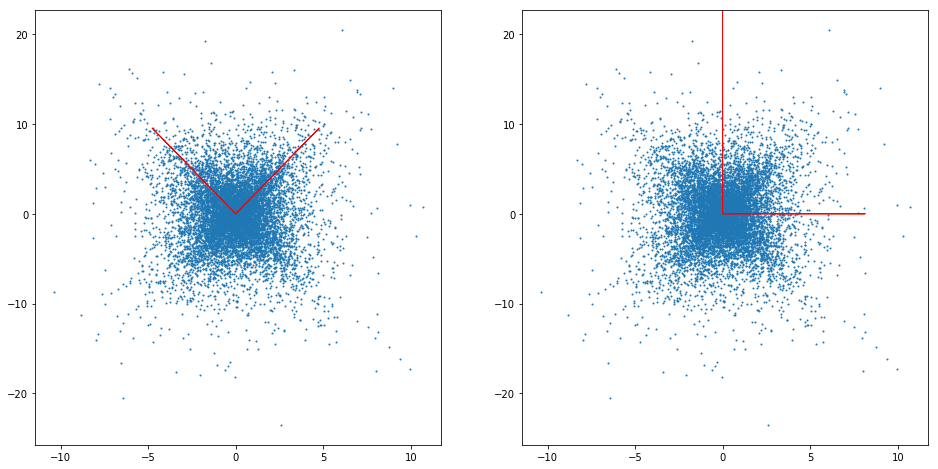

In [47]:
compareMixingMatrix(synthData, verifyA, estimateA)

We hope your implementation works well here.

### Apply ICA to Mixed Sound Tracks

Now, let's apply our algorithm to the mixed sound tracks to see what happend,

In [48]:
A, S = bss(X)

At first, let's save recoverd sound tracks to files and hear them with your ear. **One important thing, you should normalize recovered sound track before write into files. This is because the recovery may different to ground truth in scales**.

In [49]:
# normalized sound tracks
S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrackA.wav', 22050, S[0])
wavfile.write('data/separatedTrackB.wav', 22050, S[1])

Not bad, right? Then, let's illustrate the result with function created above,

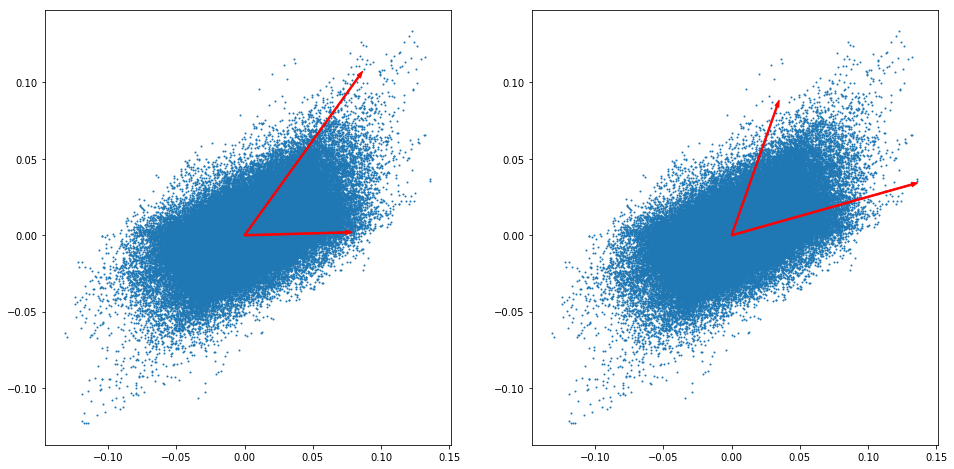

In [50]:
compareMixingMatrix(X, gtruthA, A)

They looks a little bit different in length, right? If you check the concrete number of two matrices, it would supprise you.

In [51]:
print('\nMixing Matrix (Our Estimation)\n\n', A)
print('\nMixing Matrix (Groud Truth)\n\n', gtruthA)


Mixing Matrix (Our Estimation)

 [[ 9.86522341  2.48309539]
 [ 2.48309539  6.30214706]]

Mixing Matrix (Groud Truth)

 [[ 0.21969101  0.2474352 ]
 [ 0.00552932  0.3072177 ]]


Not close, right? **Why? Does it mean probability theory don't work?** This is a problem we leave for you to think.

### Beyond the Demo

To answer above questions, you may need to do some exploration by yourself to understand this model in depth. If you have no clue where to start. We'll provide you some options:
- Draw histogram of source tracks to see whether or not it follows our assumption (Laplace distribution)
- Dig in depth of mathematical deduction of this Model, and try to understand the effect of each part

**All these suggestion are not necessary to be complete. You, of course, can do any exploration that interested you.**